### LOADING LIBRARIES

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import cv2, glob, os
import time
from pathlib import Path
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from generator import *
from utils import *

In [3]:
print(tf.__version__)

1.13.1


In [4]:
SEED = 100
np.random.seed(SEED)
tf.random.set_random_seed(SEED)

***Uncomment below cell to download data***

In [5]:
# !wget http://imagenet.stanford.edu/internal/car196/cars_annos.mat
# !wget http://imagenet.stanford.edu/internal/car196/car_ims.tgz
##!sudo apt-get install tar
# !tar xvzf car_ims.tgz

### LOADING DATA

In [6]:
!python generate_csv.py

/media/danish/Data/anaconda/envs/tf/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
img_path = Path('./')

In [7]:
data = scipy.io.loadmat('./cars_annos.mat')
classes = {i:data['class_names'][0][i][0] for i in range(data['class_names'].shape[1])}

In [8]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [9]:
train_data.target -=1
test_data.target -=1

In [10]:
train_data.head()

,filename,target
0,car_ims/006510.jpg,79
1,car_ims/009098.jpg,110
2,car_ims/013462.jpg,163
3,car_ims/010743.jpg,129
4,car_ims/012100.jpg,146


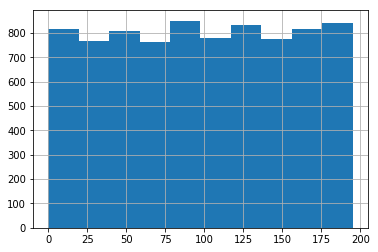

In [11]:
train_data.target.hist()

In [12]:
name_label={v:k for k,v in classes.items()}

In [13]:
def to_ohe(label,num_classes=7):
    return np.array(k.utils.to_categorical(label,num_classes=num_classes))

(184, 274, 3)


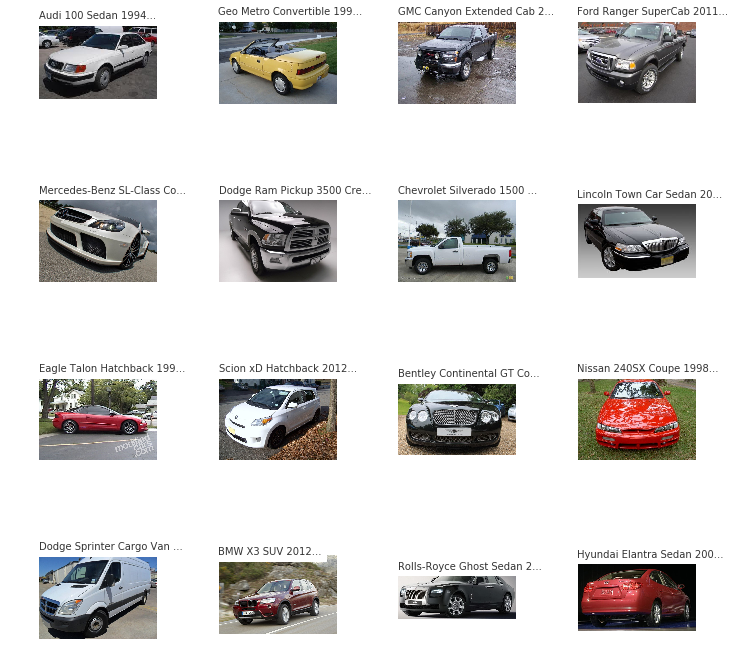

In [14]:
plot_batch_img(img_path,train_data,classes,batch=30)

In [15]:
## Splitting data into train and validation set
train_data,valid_data = train_test_split(train_data,test_size=0.1,random_state=SEED)
train_data.shape,valid_data.shape

((7236, 2), (805, 2))

### GENERATOR

In [16]:
from albumentations import (HorizontalFlip, IAAPerspective, ShiftScaleRotate,
                            CLAHE, RandomRotate90, Transpose, ShiftScaleRotate,
                            Blur, OpticalDistortion, GridDistortion,
                            HueSaturationValue, IAAAdditiveGaussianNoise,
                            GaussNoise, MotionBlur, MedianBlur,Rotate,
                            IAAPiecewiseAffine, IAASharpen, IAAEmboss,
                            RandomBrightnessContrast, Flip, OneOf, Compose)


def randomAugment(p=0.7):
    return Compose([
        HorizontalFlip(p=0.5),
        Rotate(limit=(-30,30), p=0.7),
        HueSaturationValue(p=0.2),
        GaussNoise(p=0.3),
        OneOf([
            MedianBlur(blur_limit=3, p=0.2),
            Blur(blur_limit=3, p=0.2),
        ], p=0.2),
        OneOf([
            IAASharpen(),
            RandomBrightnessContrast(),
        ], p=0.3),
    ], p=p)

In [17]:
def load_img(path):
    '''Load, Resize and Convert image from BGR format to RGB format'''
    img = cv2.imread(path)
    img = cv2.resize(img, (input_size, input_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [18]:
#Input size of the model
input_size=224

In [19]:
class DataGenerator(Sequence):
    '''Generate batch of images and target'''
    def __init__(self,df, bs,is_valid=False):
        '''Initialize the Generator class
        Parameters :
            df : DataFrame, containing names and target value of images
            bs : int , batch size
            is_valid : Bool, Flag for applying data augmentation 
        '''
    def __init__(self, df, bs, is_valid=False):
        self.df = df
        self.bs = bs
        self.is_valid = is_valid 
        self.augmentation = randomAugment(p=0.7)
        
    def __len__(self) :
        '''Return the length of the data'''
        return np.ceil(self.df.shape[0] / self.bs).astype(int)

    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        if self.is_valid == False:
            self.df = shuffle(self.df, random_state=SEED)
            self.df.reset_index(inplace=True, drop=True)

    def set_bs(self,new_bs) :
        '''Change the batch size by by passing new batch size'''
        self.bs=new_bs
    
    def __getitem__(self, idx):
        '''Generate batch of images and target'''
        x_batch, y_batch = [], []
        start = idx * self.bs
        end = (idx + 1) * self.bs
        ids_train_batch = self.df.filename[start:end].values
        labels = self.df.target[start:end].values
        for i, ids in enumerate(ids_train_batch):
            img = load_img(str(img_path / ids))
            target = to_ohe(labels[i],196)
            ## Augmentation
            if not self.is_valid:
                img = self.augmentation(image=(img).astype(np.uint8))['image']
            x_batch.append(img)
            y_batch.append(target)
        x_batch = np.array(x_batch, np.float32) / 255.
        y_batch = np.array(y_batch, np.float32)

        return x_batch, y_batch
        

In [20]:
bs = 16

In [21]:
train_generator = DataGenerator(train_data,bs,False)
valid_generator = DataGenerator(valid_data,bs,True)

In [22]:
l = train_generator.__getitem__(1)
l[0].shape,l[1].shape

((16, 224, 224, 3), (16, 196))

In [25]:
def plot_imgs(im,dic,label,bt=0,rw=4,cl=4):
    fig, axes = plt.subplots(rw,cl, figsize=(15, 10))
    for i, ax in enumerate(axes.flat):
        display_img(im[i],dic,label[i], ax=ax,ohe=True)
    plt.tight_layout(pad=0.01)

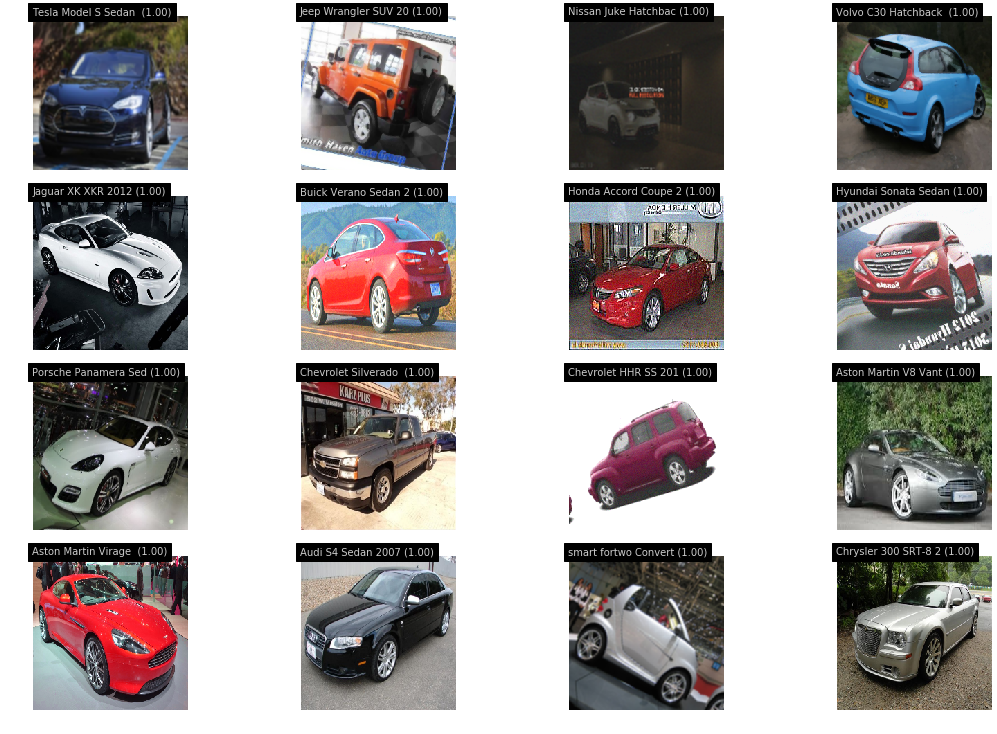

In [26]:
#Results from data generator
plot_imgs(l[0],classes,l[1])

### METRICS

In [24]:
# def precision(y_true, y_pred,thresh=0.2):
#     '''Computes the precision between predictions and ground truth'''
# #     y_pred = float(y_pred>thresh)
# #     y_true = float(y_true)
#     true_positive = tf.reduce_sum(y_pred*y_true,axis=1)
#     precision = true_positive / (tf.reduce_sum(y_pred, axis = 1)+eps)
#     return tf.reduce_mean(precision)

# def recall(y_true, y_pred,thresh=0.2):
#     '''Computes the recall between predictions and ground truth'''
# #     y_pred = float(y_pred>thresh)
# #     y_true = float(y_true)
#     true_positive = tf.reduce_sum(y_pred*y_true,axis=1)
#     recall = true_positive /  (tf.reduce_sum(y_true, axis = 1)+eps)
#     return tf.reduce_mean(recall)

In [27]:
# from sklearn.metrics import fbeta_score

# ##https://www.kaggle.com/arsenyinfo/f-beta-score-for-keras
# def fbeta(y_true, y_pred, threshold_shift=0):
#     beta = 2

#     # just in case of hipster activation at the final layer
#     y_pred = K.clip(y_pred, 0, 1)

#     # shifting the prediction threshold from .5 if needed
#     y_pred_bin = K.round(y_pred + threshold_shift)

#     tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
#     fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
#     fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

#     precision = tp / (tp + fp)
#     recall = tp / (tp + fn)

#     beta_squared = beta ** 2
#     result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
#     return tf.reduce_mean(result)

### MODEL

In [27]:
input_size=224
numclass=196

In [28]:
def get_model():
    #Pretrained Xception network without head
    pretrained_model = k.applications.ResNet50(
        weights="imagenet",
        input_tensor=k.layers.Input(shape=(input_size, input_size, 3),
                                    name='feature'),
        include_top=False)
    #Freezing the body of the network
    for layer in pretrained_model.layers:
        layer.trainable = False
    #Head of the model
    x = pretrained_model.output
    x = k.layers.GlobalAveragePooling2D()(x)
    x = k.layers.Dense(512,name='head_dense',kernel_initializer=k.initializers.he_normal(10))(x)
    x = k.layers.BatchNormalization()(x)
    x = k.layers.ReLU()(x)
    output = k.layers.Dense(numclass,
                            name='predictions',
                            activation='softmax',
                            kernel_initializer=k.initializers.he_normal(10))(x)
    model = k.Model(inputs=pretrained_model.input,
                    outputs=output,
                    name='Classification_Network')

    return model

In [29]:
model = get_model()
model.summary(110)

Instructions for updating:
Colocations handled automatically by placer.
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
feature (InputLayer)                (None, 224, 224, 3)     0                                                 
______________________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)           (None, 230, 230, 3)     0            feature[0][0]                        
______________________________________________________________________________________________________________
conv1 (Conv2D)                      (None, 112, 112, 64)    9472         conv1_pad[0][0]                      
______________________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1)     (Non

### TRAINING

In [30]:
learning_rate=0.01
adam=k.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
def fit(epoch=2):
    model.fit_generator(
        generator=train_generator,
        steps_per_epoch=int(np.ceil(train_data.shape[0]) / (bs)),
        epochs=epoch,verbose=1,
        validation_data=valid_generator,
        shuffle=True,workers=4,
        validation_steps=int(np.ceil(valid_data.shape[0]) / (bs)))

In [32]:
fit(2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
453/453 [==============================] - 59s 130ms/step - loss: 4.8325 - acc: 0.0746 - val_loss: 7.1424 - val_acc: 0.0037
Epoch 2/2
453/453 [==============================] - 68s 150ms/step - loss: 3.5171 - acc: 0.1960 - val_loss: 7.7721 - val_acc: 0.0037


In [35]:
for layer in model.layers:
    layer.trainable = True
lr = 1e-3
adam=k.optimizers.Adam(lr=lr)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [36]:
fit(20)

Epoch 1/20
453/453 [==============================] - 165s 365ms/step - loss: 5.4586 - acc: 0.0117 - val_loss: 15.9996 - val_acc: 0.0075
Epoch 2/20
453/453 [==============================] - 232s 513ms/step - loss: 5.3702 - acc: 0.0075 - val_loss: 5.2891 - val_acc: 0.0124
Epoch 3/20
453/453 [==============================] - 323s 712ms/step - loss: 5.3027 - acc: 0.0086 - val_loss: 6.1495 - val_acc: 0.0137
Epoch 4/20
453/453 [==============================] - 323s 713ms/step - loss: 5.2832 - acc: 0.0090 - val_loss: 6.2479 - val_acc: 0.0161
Epoch 5/20
173/453 [==========>...................] - ETA: 3:19 - loss: 5.2353 - acc: 0.0105

KeyboardInterrupt: 

In [ ]:
k.backend.set_value(adam.lr,lr/3)
fit(10)